In [3]:
%matplotlib inline
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [38]:
import skgeom as sg
from skgeom.draw import draw

In [54]:
def toPoint2(p):
    return sg.Point2(p[0], p[1])

def toVector(p1, p2):
    # Return vector witch homogeneos coordenate
    v = np.array(p1) - np.array(p2)
    return np.array([v[0], v[1], 1])

def makePoints(n, mean=0, std=1):
    np.random.seed(21)
    xSample = np.random.normal(mean, std, n)
    ySample = np.random.normal(mean, std, n)
    return list(zip(xSample, ySample))

def list_splice(target, start, delete_count=None, *items):
    """Remove existing elements and/or add new elements to a list.

    target        the target list (will be changed)
    start         index of starting position
    delete_count  number of items to remove (default: len(target) - start)
    *items        items to insert at start index

    Returns a new list of removed items (or an empty list)
    """
    if delete_count == None:
        delete_count = len(target) - start

    # store removed range in a separate list and replace with *items
    total = start + delete_count
    removed = target[start:total]
    target[start:total] = items

    return removed

def giftWrapping(pts_):
    pts = pts_[:]
    pts.sort(key=lambda x: x[0]) # ordenamos por el eje x

    hull = []
    index = 2
    nextIndex = -1
    
    leftMost = pts[0]
    currentVertex = leftMost
    hull.append(currentVertex)
    nextVertex = pts[1]
    try:
        while True:
            #print(len(pts), index)
            checkingPoint = pts[index]
            u = toVector(nextVertex, currentVertex)
            v = toVector(checkingPoint, currentVertex)
            cross = np.cross(u, v)
            if cross[2]>0:
                nextVertex = checkingPoint
                nextIndex = index
            index += 1
            if index == len(pts):
                if nextVertex == leftMost:
                    print('Termino hull..')
                    return hull
                else:
                    hull.append(nextVertex)
                    currentVertex = nextVertex
                    index = 0
                    # splice..
                    _ = list_splice(pts, nextIndex, 1) #pts = pts[nextIndex:]
                    nextVertex = leftMost
    except Exception as e:
        print('Exception:', e)
        return hull
    return hull

def getDistance(p1, p2, distance_metric='euclidean'):
    dst = None
    if distance_metric=='euclidean':
        dst = distance.euclidean(p1, p2)
    elif distance_metric=='mahalanobis':
        x_p1, y_p1 = p1
        x_p2, y_p2 = p2
        # numpy.inv with determinat 0, we use numpy.pinv to leverages SVD to approximate initial matrix
        V = np.cov(np.array([[x_p1, y_p1, 1], [x_p2, y_p2, 1]]).T)
        IV = np.linalg.pinv(V)
        dst = distance.mahalanobis([x_p1, y_p1, 1], [x_p2, y_p2, 1], IV)
    else:
        print("ERRO: Distance metric not found: ", distance_metric)
    return dst

def onion_peeling_outtlier_detection(S, k, distance_metric='euclidean'):
    L = []
    S_ = S[:] # make copy points
    mean = np.mean(S, axis=0) # to take the mean of each col
    while True:
        # Run Convex-Hull algorithm
        hull = giftWrapping(S_)
        
        # check the size of points
        if len(S_)<k:
            print('Size of points must be greater than outliers.')
            return L, hull
        
        # Start removing points one at a time
        print('Finding points...')
        dst = []
        # Calculate distance with requested distance metric
        for pt in hull:
            dst.append(getDistance(pt, mean, distance_metric))
        # Find the point with largest distance to all the points in the data
        idx_pt = np.argmax(dst)
        idx_ = S_.index(hull[idx_pt])
        # We remove the furthest point found in Hull
        remove = list_splice(S_, idx_, 1)
        # Store the point and the corresponding index in the memory.
        L.append(remove[0])
        if len(L)==k:
            return L, giftWrapping(S_)
        # Remove the current hull.
        hull = None

In [57]:
n = 100
k = 10
points = makePoints(n)
#res = giftWrapping(points)
#print(len(res))
outliers, hull_res = onion_peeling_outtlier_detection(points, k, distance_metric='euclidean')
print(outliers)

Termino hull..
Finding points...
Termino hull..
Finding points...
Termino hull..
Finding points...
Termino hull..
Finding points...
Termino hull..
Finding points...
Termino hull..
Finding points...
Termino hull..
Finding points...
Termino hull..
Finding points...
Termino hull..
Finding points...
Termino hull..
Finding points...
Termino hull..
[(0.5737089363593981, 3.094481548077701), (-2.859687985885645, 0.03740545935167208), (2.7550032972015845, 0.35921196283852047), (2.602813278409246, 0.41139831254769854), (2.519898365204564, -0.7899115362710363), (-1.9832778283639318, 0.882776947060921), (2.010792808346442, -1.387554611242791), (1.6795509743129613, -1.660613176262325), (-1.5090823541061125, -1.5620812393396624), (-1.7473337953315786, 0.9568129316981235)]


## Plot using SKGEOM

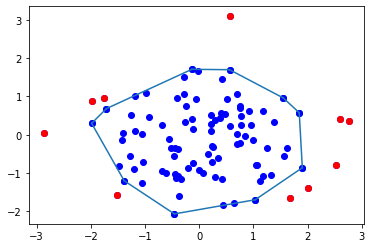

In [58]:
# plot todos los puntos que estaban previamente ordenados
# y resaltamos de color rojo el
points_sg = []
for i in range(n):
    x, y = points[i]
    points_sg.append(sg.Point2(x, y))
    
#draw(toPoint2(leftMost), color='red') # Draw only the leftMost point

#draw(sg.Segment2(toPoint2(currentVertex),toPoint2(nextVertex)))
#draw(sg.Segment2(toPoint2(currentVertex),toPoint2(checkingPoint)), color='green')
#draw(toPoint2(currentVertex), color='orange') # Draw only the currentVertex point

#res = [(-1.7110537607276717, 0.231802959660187), (-0.6132002869132012, 1.5678821766222575), (-0.6132002869132012, 1.5678821766222575), (1.3736884997604164, 1.1785562058590144), (1.6109919764383442, -1.383956868577714), (1.6109919764383442, -1.383956868577714)]
#hull_poly = sg.Polygon(res)
#draw(hull_poly)
for i in range(len(hull_res)-1):
    draw(sg.Segment2(toPoint2(hull_res[i]),toPoint2(hull_res[i+1])))
draw(sg.Segment2(toPoint2(hull_res[-1]),toPoint2(hull_res[0])))
    
draw(points_sg, color='blue') # draw all points

points_outliers = []
for i in range(len(outliers)):
    x, y = outliers[i]
    points_outliers.append(sg.Point2(x, y))
draw(points_outliers, color='red')

In [174]:
# https://gist.github.com/WetHat/d69ce0e94e337538e5b4c848501522aa